In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from scipy.constants import h,k,c
from scipy.optimize import minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
#from astropy.analytic_functions import blackbody_lambda, blackbody_nu
import time
import emcee

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
Dependencies imported


In [2]:
filternamevec = ['PSg','PSr','PSi','PSz','PSy','Gaia','BJohnson','VJohnson','SDSSg','SDSSr','SDSSi','J','H','K','W1','W2','W3','W4']
filterzps = [3631., 3631., 3631., 3631., 3631., 2861.3, 4000.87, 3597.28, 3631., 3631., 3631., 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 0.673, 0.4361, 0.5448, 0.4770, 0.6231, 0.7625, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

filterzps_short = filterzps[-7:]
#filterzps_nops = filterzps[5:]
#filterzps_nogaia = filterzps[6:]

#filterzps_dict = {filtercentwav[i]: filterzps[i] for i in range(len(filtercentwav))}

filterzps_dict = {}

for i in range(len(filtercentwav)):
    filterzps_dict[filtercentwav[i]] = filterzps[i]

class FullSubject:
    def __init__(self, vec, vec1):
        self.zooniverse_id = vec[8]
        self.wiseid = vec[7]
        self.ra = float(vec[1])
        self.dec = float(vec[2])
        self.glong = float(vec[9])
        self.glat = float(vec[10])

        self.jmag = float(vec[19])
        self.jmagerr = float(vec[20])
        self.hmag = float(vec[21])
        self.hmagerr = float(vec[22])
        self.kmag = float(vec[23])
        self.kmagerr = float(vec[24])
        tempw1mag = float(vec[11])
        tempw1magerr = float(vec[12])
        tempw2mag = float(vec[13])
        tempw2magerr = float(vec[14])
        self.w3mag = float(vec[15])
        self.w3magerr = float(vec[16])
        self.w4mag = float(vec[17])
        self.w4magerr = float(vec[18])
        
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
            
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5

        self.psgmag = float(vec[54])
        self.psgmagerr = float(vec[55])
        self.psimag = float(vec[56])
        self.psimagerr = float(vec[57])
        self.psrmag = float(vec[58])
        self.psrmagerr = float(vec[59])
        self.psymag = float(vec[60])
        self.psymagerr = float(vec[61])
        self.pszmag = float(vec[62])
        self.pszmagerr = float(vec[63])
        
        self.has_ps_gminr = (not math.isnan(self.psgmag)) and (not math.isnan(self.psrmag))
        if self.has_ps_gminr:
            self.psgminr = self.psgmag - self.psrmag
            self.psgminrerr = ((self.psgmagerr**2) + (self.psrmagerr**2))**0.5
        else:
            self.psgminr = float('NaN')
        
        self.sourcevec = vec
        
        self.gaiamag = float(vec[43])
        self.gaiamagerr = float(vec[45])
        #if not math.isnan(float(vec[80])):
        #    self.bjmag = float(vec[80])
        #    self.bjmagerr = float(vec[81])
        #elif not math.isnan(float(vec[35])) and (float(vec[35]) > 0.) and (float(vec[35]) < 5.) and (float(vec[29]) < 50.):
        #    self.bjmag = float(vec[29])
        #    self.bjmagerr = float(vec[35])
        self.bjmag_tycho = float(vec[80])
        self.bjmagerr_tycho = float(vec[81])        
        self.vjmag_tycho = float(vec[82])
        self.vjmagerr_tycho = float(vec[83])
        
        self.has_tycho_vmag = (not math.isnan(self.vjmag_tycho))
        self.has_gaia = (not math.isnan(self.gaiamag))
        self.has_tycho_bmag = (not math.isnan(self.bjmag_tycho))
        
        self.apass_vmag = float(vec[27])
        self.apass_bmag = float(vec[29])
        self.apass_gmag = float(vec[30])
        self.apass_rmag = float(vec[31])
        self.apass_imag = float(vec[32])
        
        self.apass_vmagerr = float(vec[33])
        self.apass_bmagerr = float(vec[35])
        self.apass_gmagerr = float(vec[36])
        self.apass_rmagerr = float(vec[37])
        self.apass_imagerr = float(vec[38])

        self.umag = float(vec[84])
        self.gmag = float(vec[86])
        self.rmag = float(vec[88])
        self.imag = float(vec[90])
        self.zmag = float(vec[92])
        
        self.umagerr = float(vec[85])
        self.gmagerr = float(vec[87])
        self.rmagerr = float(vec[89])
        self.imagerr = float(vec[91])
        self.zmagerr = float(vec[93])
        
        self.use_tycho = vec[94] in ['TRUE','True','true']
        self.use_gaia = vec[95] in ['TRUE','True','true']
        self.use_ps = vec[96] in ['TRUE','True','true']
        self.use_sdss = vec[97] in ['TRUE','True','true']

        
        filtinputvec = [self.psgmag, self.psrmag, self.psimag, self.pszmag, self.psymag, self.gaiamag, self.bjmag_tycho, self.vjmag_tycho, self.gmag, self.rmag, self.imag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        filterrinputvec = [self.psgmagerr, self.psrmagerr, self.psimagerr, self.pszmagerr, self.psymagerr, self.gaiamagerr, self.bjmagerr_tycho, self.vjmagerr_tycho, self.gmagerr, self.rmagerr, self.imagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        
        self.filts_temp = []
        self.mags_temp = []
        self.magerrs_temp = []
        self.fluxes_temp = []
        self.fluxerrs_temp = []
        self.centwavs_temp = []
        self.filterzps_temp = []
        
        self.filts_nops_temp = []
        self.mags_nops_temp = []
        self.magerrs_nops_temp = []
        self.fluxes_nops_temp = []
        self.fluxerrs_nops_temp = []
        self.centwavs_nops_temp = []
        self.filterzps_nops_temp = []
        
        self.filts_to_use_temp = []
        self.mags_to_use_temp = []
        self.magerrs_to_use_temp = []
        self.fluxes_to_use_temp = []
        self.fluxerrs_to_use_temp = []
        self.centwavs_to_use_temp = []
        self.filterzps_to_use_temp = []
        
        for i in range(len(filtinputvec)):
            #print filtinputvec[i]
            if math.isnan(filtinputvec[i]):
                continue
            else:
                self.filts_temp.append(filternamevec[i])
                self.mags_temp.append(filtinputvec[i])
                self.magerrs_temp.append(filterrinputvec[i])
                self.fluxes_temp.append(filterzps[i] * (10.**(-0.4*filtinputvec[i])))
                self.fluxerrs_temp.append(0.4*np.log(10.)*filterrinputvec[i]*(filterzps[i] * (10.**(-0.4*filtinputvec[i]))))
                self.centwavs_temp.append(filtercentwav[i])
                self.filterzps_temp.append(filterzps[i])

        for i in range(len(self.filts_temp)):
            if 'PS' not in self.filts_temp[i]:
                #if (self.has_tycho_vmag or self.has_tycho_bmag) and ('Gaia' not in self.filts_temp[i]):
                #    self.filts_nogaia_temp.append(self.filts_temp[i])
                #    self.mags_nogaia_temp.append(self.mags_temp[i])
                #    self.magerrs_nogaia_temp.append(self.magerrs_temp[i])
                #    self.fluxes_nogaia_temp.append(self.fluxes_temp[i])
                #    self.fluxerrs_nogaia_temp.append(self.fluxerrs_temp[i])
                #    self.centwavs_nogaia_temp.append(self.centwavs_temp[i])
                #    self.filterzps_nogaia_temp.append(self.filterzps_temp[i])

                self.filts_nops_temp.append(self.filts_temp[i])
                self.mags_nops_temp.append(self.mags_temp[i])
                self.magerrs_nops_temp.append(self.magerrs_temp[i])
                self.fluxes_nops_temp.append(self.fluxes_temp[i])
                self.fluxerrs_nops_temp.append(self.fluxerrs_temp[i])
                self.centwavs_nops_temp.append(self.centwavs_temp[i])
                self.filterzps_nops_temp.append(self.filterzps_temp[i])
                
        for i in range(len(self.filts_temp)):
            if 'PS' in self.filts_temp[i] and not self.use_ps:
                continue
            elif 'SDSS' in self.filts_temp[i] and not self.use_sdss:
                continue
            elif 'Johnson' in self.filts_temp[i] and not self.use_tycho:
                continue
            elif 'Gaia' in self.filts_temp[i] and not self.use_gaia:
                continue
            else:
                self.filts_to_use_temp.append(self.filts_temp[i])
                self.mags_to_use_temp.append(self.mags_temp[i])
                self.magerrs_to_use_temp.append(self.magerrs_temp[i])
                self.fluxes_to_use_temp.append(self.fluxes_temp[i])
                self.fluxerrs_to_use_temp.append(self.fluxerrs_temp[i])
                self.centwavs_to_use_temp.append(self.centwavs_temp[i])
                self.filterzps_to_use_temp.append(self.filterzps_temp[i])
                #print self.filts_to_use_temp
                
                
                
        self.filts_long = np.array(self.filts_temp)
        self.mags_long = np.array(self.mags_temp)
        self.magerrs_long = np.array(self.magerrs_temp)
        self.fluxes_long = np.array(self.fluxes_temp) * 1.e-23
        self.fluxerrs_long = np.array(self.fluxerrs_temp) * 1.e-23
        self.centwavs_microns_long = np.array(self.centwavs_temp)
        self.centwavs_meters_long = self.centwavs_microns_long * 1.e-6
        self.centwavs_Hz_long = c/self.centwavs_meters_long
        self.nuFnu_long = self.centwavs_Hz_long * self.fluxes_long
        self.nuFnuerrs_long = self.centwavs_Hz_long * self.fluxerrs_long
        
        self.filts_nops = np.array(self.filts_nops_temp)
        self.mags_nops = np.array(self.mags_nops_temp)
        self.magerrs_nops = np.array(self.magerrs_nops_temp)
        self.fluxes_nops = np.array(self.fluxes_nops_temp) * 1.e-23
        self.fluxerrs_nops = np.array(self.fluxerrs_nops_temp) * 1.e-23
        self.centwavs_microns_nops = np.array(self.centwavs_nops_temp)
        self.centwavs_meters_nops = self.centwavs_microns_nops * 1.e-6
        self.centwavs_Hz_nops = c/self.centwavs_meters_nops
        self.nuFnu_nops = self.centwavs_Hz_nops * self.fluxes_nops
        self.nuFnuerrs_nops = self.centwavs_Hz_nops * self.fluxerrs_nops
        self.filterzps_nops = np.array(self.filterzps_nops_temp)
        
        self.filts_to_use = np.array(self.filts_to_use_temp)
        self.mags_to_use = np.array(self.mags_to_use_temp)
        self.magerrs_to_use = np.array(self.magerrs_to_use_temp)
        self.fluxes_to_use = np.array(self.fluxes_to_use_temp) * 1.e-23
        self.fluxerrs_to_use = np.array(self.fluxerrs_to_use_temp) * 1.e-23
        self.centwavs_microns_to_use = np.array(self.centwavs_to_use_temp)
        self.centwavs_meters_to_use = self.centwavs_microns_to_use * 1.e-6
        self.centwavs_Hz_to_use = c/self.centwavs_meters_to_use
        self.nuFnu_to_use = self.centwavs_Hz_to_use * self.fluxes_to_use
        self.nuFnuerrs_to_use = self.centwavs_Hz_to_use * self.fluxerrs_to_use
        self.filterzps_to_use = np.array(self.filterzps_to_use_temp)
        
        self.centwavs_microns = self.centwavs_microns_long[-7:]
        self.centwavs_meters = self.centwavs_microns * 1.e-6
        self.centwavs_Hz = c/self.centwavs_meters
        self.mags = self.mags_long[-7:]
        self.magerrs = self.magerrs_long[-7:]
        self.nuFnu = self.nuFnu_long[-7:]
        self.nuFnuerrs = self.nuFnuerrs_long[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        
        self.Teff = None
        self.Teff_err_low = None
        self.Teff_err_high = None
        self.logg = None
        self.logg_err_low = None
        self.logg_err_high = None
        self.rdstar = None
        self.rdstar_err_low = None
        self.rdstar_err_high = None
        self.Tdisk = None
        self.Tdisk_err_low = None
        self.Tdisk_err_high = None
        self.xdisk = None
        self.xdisk_err_low = None
        self.xdisk_err_high = None
        self.fir = None
        self.fir_err_low = None
        self.fir_err_high = None
        
        if vec1[2] != 'None':
            self.Teff = float(vec1[2])
        if vec1[3] != 'None':
            self.Teff_err_low = float(vec1[3])
        if vec1[4] != 'None':
            self.Teff_err_high = float(vec1[4])

        #print vec1[5]
        if vec1[5] != 'None':
            self.logg = float(vec1[5])
            self.use_models = True
        else:
            self.use_models = False
 

        if vec1[8] != 'None':
            self.rdstar = float(vec1[8])
        if vec1[9] != 'None':
            self.rdstar_err_low = float(vec1[9])
        if vec1[10] != 'None':
            self.rdstar_err_high = float(vec1[10])
        
        if vec1[11] != 'None':
            self.Tdisk = float(vec1[11])
        if vec1[12] != 'None':
            self.Tdisk_err_low = float(vec1[12])
        if vec1[13] != 'None':
            self.Tdisk_err_high = float(vec1[13])

        if vec1[14] != 'None':
            self.xdisk = float(vec1[14])
        if vec1[15] != 'None':
            self.xdisk_err_low = float(vec1[15])
        if vec1[16] != 'None':
            self.xdisk_err_high = float(vec1[16])

        self.fir = float(vec1[17])
        self.fir_err_low = float(vec1[18])
        self.fir_err_high = float(vec1[19])


    def __str__(self):
        s = ''

        string_vec =[subj.zooniverse_id, subj.wiseid, str(subj.Teff), str(subj.Teff_err_low), str(subj.Teff_err_high), str(subj.rdstar), str(subj.rdstar_err_low), str(subj.rdstar_err_high), str(subj.Tdisk), str(subj.Tdisk_err_low), str(subj.Tdisk_err_high), str(subj.xdisk), str(subj.xdisk_err_low), str(subj.xdisk_err_high), str(subj.fir), str(subj.fir_err_low), str(subj.fir_err_high)]

        for entry in string_vec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


In [3]:
def get_data(filename, filename1):
    df = read_csv(filename, low_memory = False)
    
    data = df.values

    df1 = read_csv(filename1, low_memory = False)
    
    data1 = df1.values

    return data, data1

In [10]:
inputdata, inputdata1 = get_data('additional_candidates_sed_input_data.csv', 'additional_candidates_disk_parameters_full.csv')

#print inputdata[1,:]

columnlabels = inputdata[1,:]

columncount = columnlabels.size

columnlabel_index_dict = {}

for i in range(columncount):
    columnlabel_index_dict[columnlabels[i]] = i

    
#from pprint import pprint
#pprint(columnlabel_index_dict)
    
inputdata_use = inputdata[5:,:]

#print inputdata_use.shape

num_subjs = inputdata_use[:,0].size

raw_subjs = []

for i in range(num_subjs):
    raw_subjs.append(FullSubject(inputdata_use[i,:], inputdata1[i,:]))
    #print i
    
print "Subjects read in"

Subjects read in


In [6]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict


cent_wavs_dict = {}
    
cent_wavs_dict_keys = np.array([0.673, 0.4361, 0.5448, 0.3543, 0.4770, 0.6231, 0.7625, 0.9134, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]) * 1.e-6

for i in range(cent_wavs_dict_keys.size):
    cent_wavs_dict[cent_wavs_dict_keys[i]] = i
    
btsettl_column_labels = ['Teff', 'Logg','G','B','V','u','g','r','i','z','J','H','K','W1_W10','W2_W10','W3_W10','W4_W10']


plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

In [7]:
def plot_number_formatting(input):
    '''Formats exponential numbers in normal scientific notation for plotting purposes'''

    teststring = '%.4e' % input
    index = teststring.index('e')
    backindex = index - len(teststring)
    firstpartfloat = float(teststring[:backindex])
    secondpartint = int(teststring[(backindex+1):])

    #formatted_string = '$%.4f \times 10^{%d}$' % (firstpartfloat, secondpartint)

    return firstpartfloat, secondpartint

In [13]:
def plot_subj(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.95)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.16)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    #if subj.good_disk_fit:
    plt.plot(plotting_x_vec, subj.nuFnu_star_plotting, linestyle=':', label='Stellar Model')
    plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting, linestyle='--', label='Disk Blackbody')
    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting, label='Total')
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
    #    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    if subj.use_models:
        if subj.fir > 0.01:
            plt.annotate(subj.wiseid+'\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f (_{-%.4f \times 10^{%d}}^{+%.4f \times 10^{%d}})$' % (subj.Teff, subj.Tdisk, subj.Tdisk_err_low, subj.Tdisk_err_high, subj.fir, plot_number_formatting(subj.fir_err_low)[0], plot_number_formatting(subj.fir_err_low)[1], plot_number_formatting(subj.fir_err_high)[0], plot_number_formatting(subj.fir_err_high)[1]), xy=(0.5, 0.78), xycoords = 'axes fraction', fontsize=12)
        else:
            plt.annotate(subj.wiseid+'\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d} (_{-%.4f \times 10^{%d}}^{+%.4f \times 10^{%d}})$' % (subj.Teff, subj.Tdisk, subj.Tdisk_err_low, subj.Tdisk_err_high, plot_number_formatting(subj.fir)[0], plot_number_formatting(subj.fir)[1], plot_number_formatting(subj.fir_err_low)[0], plot_number_formatting(subj.fir_err_low)[1], plot_number_formatting(subj.fir_err_high)[0], plot_number_formatting(subj.fir_err_high)[1]), xy=(0.5, 0.78), xycoords = 'axes fraction', fontsize=12)

    else:
        if subj.fir > 0.01:
            plt.annotate(subj.wiseid+'\n' r'$T_{\mathrm{star}} = %.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$T_{\mathrm{disk}}=%.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f (_{-%.4f \times 10^{%d}}^{+%.4f \times 10^{%d}})$' % (subj.Teff, subj.Teff_err_low, subj.Teff_err_high, subj.Tdisk, subj.Tdisk_err_low, subj.Tdisk_err_high, subj.fir, plot_number_formatting(subj.fir_err_low)[0], plot_number_formatting(subj.fir_err_low)[1], plot_number_formatting(subj.fir_err_high)[0], plot_number_formatting(subj.fir_err_high)[1]), xy=(0.5, 0.78), xycoords = 'axes fraction', fontsize=12)
        else:
            plt.annotate(subj.wiseid+'\n' r'$T_{\mathrm{star}} = %.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$T_{\mathrm{disk}}=%.0f_{-%.0f}^{+%.0f}$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d} (_{-%.4f \times 10^{%d}}^{+%.4f \times 10^{%d}})$' % (subj.Teff, subj.Teff_err_low, subj.Teff_err_high, subj.Tdisk, subj.Tdisk_err_low, subj.Tdisk_err_high, plot_number_formatting(subj.fir)[0], plot_number_formatting(subj.fir)[1], plot_number_formatting(subj.fir_err_low)[0], plot_number_formatting(subj.fir_err_low)[1], plot_number_formatting(subj.fir_err_high)[0], plot_number_formatting(subj.fir_err_high)[1]), xy=(0.5, 0.78), xycoords = 'axes fraction', fontsize=12)


        
    plt.legend(loc='lower left',fontsize=12)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(ymin), 10.**(ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)
    
    #if len(subjs_with_star_fits) < 2:
    #plt.savefig('/discover/nobackup/ssilverb/new_plots_2018-02-14/'+subj.zooniverse_id+'_modelfit.pdf')
    
    #plt.close()
    
    plt.show()
    return


def plot_subj_no_uncertainty(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.21)
    plt.gcf().subplots_adjust(right=0.96)
    plt.gcf().subplots_adjust(top=0.96)
    plt.gcf().subplots_adjust(bottom=0.18)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='ko', markersize=5.)
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    #if subj.good_disk_fit:
    plt.plot(plotting_x_vec, subj.nuFnu_star_plotting, linestyle=':', label='Stellar Model')
    plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting, linestyle='--', label='Disk Blackbody')
    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting, label='Total')
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
    #    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    plt.xlim([0.25, 100.])
    plt.ylim([10.**(ymin), 10.**(ymax)])

    if subj.use_models:
        if subj.fir > 0.01:
            plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f$' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)
        else:
            plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d}$' % (subj.Teff, subj.Tdisk, plot_number_formatting(subj.fir)[0], plot_number_formatting(subj.fir)[1]), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)

    else:
        if subj.fir > 0.01:
            plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f$' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)
        else:
            plt.annotate(r'$\mathrm{'+subj.wiseid+'}$' '\n' r'$T_{\mathrm{star}} = %.0f$ K' '\n' r'$T_{\mathrm{disk}}=%.0f$ K' '\n' r'$L_{\mathrm{ir}}/L_{\mathrm{star}} = %.4f \times 10^{%d}$' % (subj.Teff, subj.Tdisk, plot_number_formatting(subj.fir)[0], plot_number_formatting(subj.fir)[1]), xy=(0.52, 0.7), xycoords = 'axes fraction', fontsize=16)


        
    plt.legend(loc='lower left',fontsize=14)
    
    
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=24)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=24)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig('sedplotting_no_unc/'+subj.zooniverse_id+'_modelfit.pdf')
    
    plt.close()
    
    #plt.show()
    return

AWI0001q7h J221158.73+594044.9


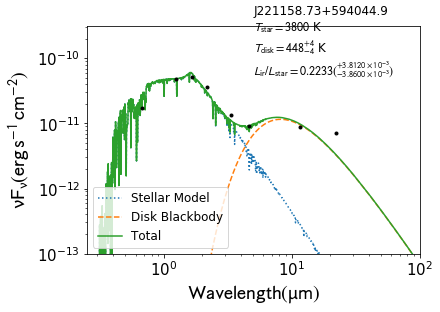

AWI00019i2 J221055.01+575629.4


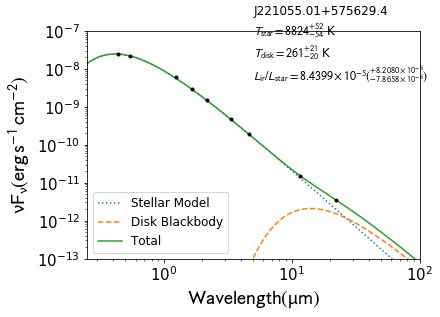

AWI0001qsl J053815.82+374440.5


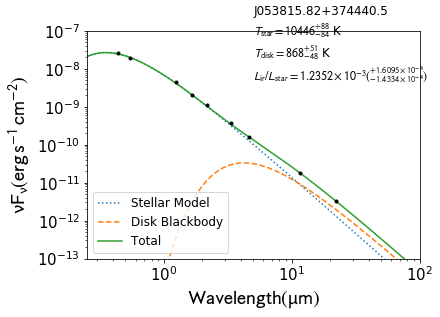

AWI00018m1 J194022.79+251648.4


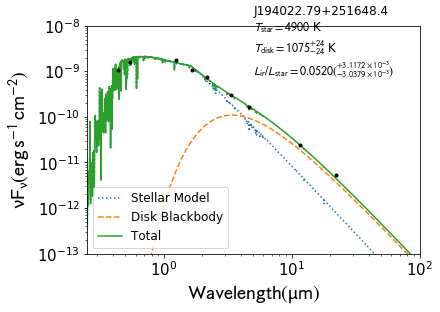

AWI00021on J192136.46+220744.7


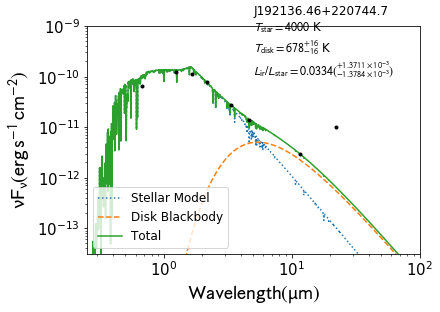

Done


In [11]:
for subj in raw_subjs:
    print subj.zooniverse_id, subj.wiseid

    if subj.use_models:
        teffpull = '0'+str(int(subj.Teff/100))
        loggpull = str(subj.logg)
        
        spect_file = 'BTSettlstuff_use/BT-Settl_M-0.0a+0.0/lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        flux_spec_S = spec_X * spec_S * (subj.rdstar**2)
        subj.nuFnu_star_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)
        
        
    else:
        subj.nuFnu_star_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, (subj.Teff)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((subj.rdstar)**2) * u.cm * u.cm * u.s / u.erg
    

    subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, (subj.Tdisk)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (subj.xdisk) * u.cm * u.cm * u.s / u.erg
            
    subj.nuFnu_model_plotting = subj.nuFnu_star_plotting + subj.nuFnu_disk_plotting

    plot_subj(subj)
    
print "Done"
    

In [14]:
for subj in raw_subjs:
    print subj.zooniverse_id, subj.wiseid
    plot_subj_no_uncertainty(subj)
    
print "Done"

AWI0001q7h J221158.73+594044.9
AWI00019i2 J221055.01+575629.4
AWI0001qsl J053815.82+374440.5
AWI00018m1 J194022.79+251648.4
AWI00021on J192136.46+220744.7
Done
